# Code for Statistical Machine Learning Practical

## Import Library and Load Dataset

In [3]:
# include
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from feature_engine.transformation import YeoJohnsonTransformer
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy.stats import bootstrap

In [4]:
# include
# Load the training data and the public test set
X_fps_train, X_embed_train = pd.read_csv('X_fps_train.csv', index_col = 0), pd.read_csv('X_embed_train.csv', index_col = 0) # training data
y_train = pd.read_csv('y_train.csv', index_col = 0).to_numpy() # training label

X_fps_public_test, X_embed_public_test = pd.read_csv('X_fps_public_test.csv', index_col = 0), pd.read_csv('X_embed_public_test.csv', index_col = 0) # public test set
y_public_test = pd.read_csv('y_public_test.csv', index_col = 0) # public test label

X_fps_private_test, X_embed_private_test = pd.read_csv('X_fps_private_test.csv', index_col = 0), pd.read_csv('X_embed_private_test.csv', index_col = 0) # private test set 

## 1. EDA

### 1.1 EDA for Embed Features

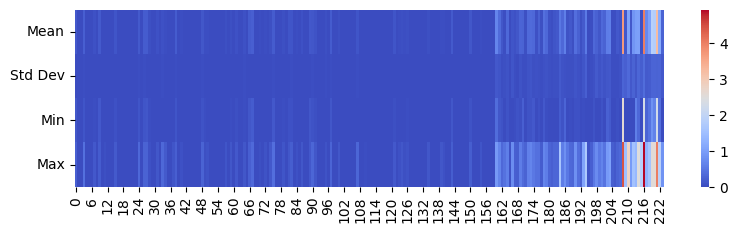

In [5]:
# Create DataFrame for heatmap
embed_feature_summary = pd.DataFrame({
    'Mean': X_embed_train.mean(),
    'Std Dev': X_embed_train.std(),
    'Min': X_embed_train.min(),
    'Max': X_embed_train.max()
    })

plt.figure(figsize=(9.5, 2.3))
sns.heatmap(embed_feature_summary.T, cmap="coolwarm", annot=False)
# plt.title("Heatmap for Selected Summary Statistics")
plt.savefig("./imgs/embed_heatmap_summary_stats.png", bbox_inches="tight")
plt.show()

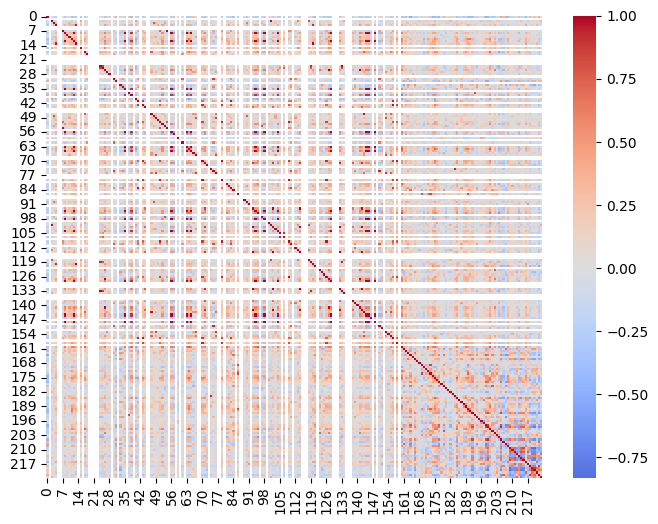

In [6]:
# Compute correlation matrix
embed_corr_matrix = X_embed_train.corr()

# Plot heatmap of correlations
plt.figure(figsize=(8, 6))
sns.heatmap(embed_corr_matrix, cmap="coolwarm", center=0, annot=False)
# plt.title("Feature Correlation Matrix")
plt.savefig("./imgs/embed_correlation_heatmap.png", bbox_inches="tight")
plt.show()

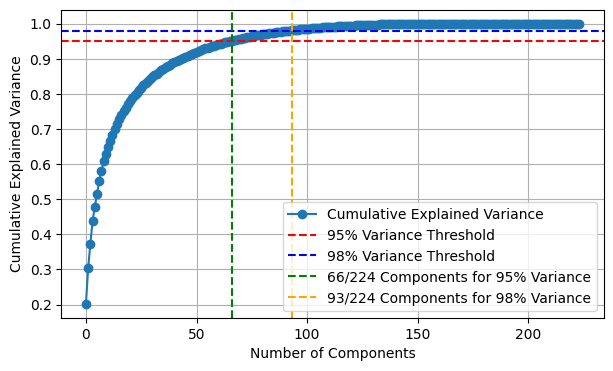

In [7]:
# Normalize the data first, then fit PCA
embed_pca = PCA().fit(StandardScaler().fit_transform(X_embed_train))
embed_cumulative_variance = np.cumsum(embed_pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.figure(figsize=(7, 4))
plt.plot(embed_cumulative_variance, marker="o", label="Cumulative Explained Variance")
plt.axhline(y=0.95, color='red', linestyle='--', label="95% Variance Threshold")  # Add 95% line
plt.axhline(y=0.98, color='blue', linestyle='--', label="98% Variance Threshold")  # Add 98% line

# Find number of components for 95% and 98% variance
embed_n_components_95 = np.argmax(embed_cumulative_variance >= 0.95) + 1
plt.axvline(x=embed_n_components_95, color='green', linestyle='--', label=f"{embed_n_components_95}/224 Components for 95% Variance")
embed_n_components_98 = np.argmax(embed_cumulative_variance >= 0.98) + 1
plt.axvline(x=embed_n_components_98, color='orange', linestyle='--', label=f"{embed_n_components_98}/224 Components for 98% Variance")

plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
# plt.title("PCA for Embed Data: Variance Explained by Number of Components")
plt.legend()
plt.grid()
plt.savefig("./imgs/embed_PCA.png", bbox_inches="tight")
plt.show()

### 1.2 EDA for Fps Features

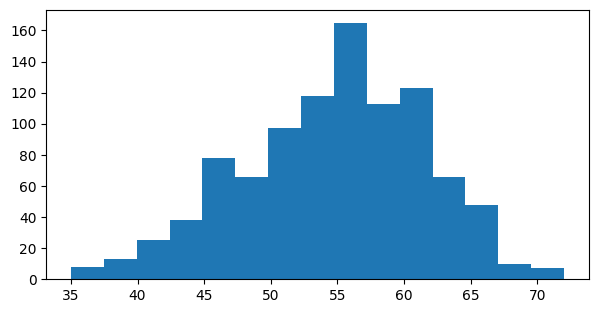

In [8]:
num_non_zero_features = X_fps_train.sum(axis=1)
plt.figure(figsize= (7,3.5))
plt.hist(num_non_zero_features, bins=15)
plt.savefig("./imgs/fps_summary.png", bbox_inches="tight")
plt.show()

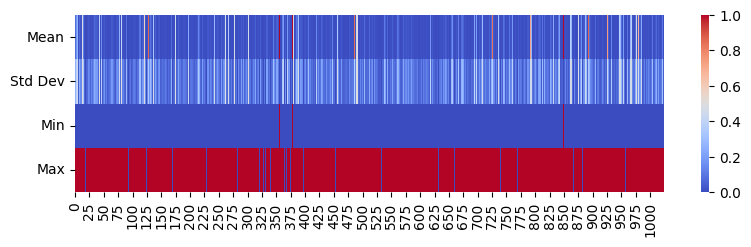

In [9]:
# Create DataFrame for heatmap
fps_feature_summary = pd.DataFrame({
    'Mean': X_fps_train.mean(),
    'Std Dev': X_fps_train.std(),
    'Min': X_fps_train.min(),
    'Max': X_fps_train.max()
    })

plt.figure(figsize=(9.5, 2.3))
sns.heatmap(fps_feature_summary.T, cmap="coolwarm", annot=False)
plt.savefig("./imgs/fps_summary_h.png", bbox_inches="tight")
plt.show()

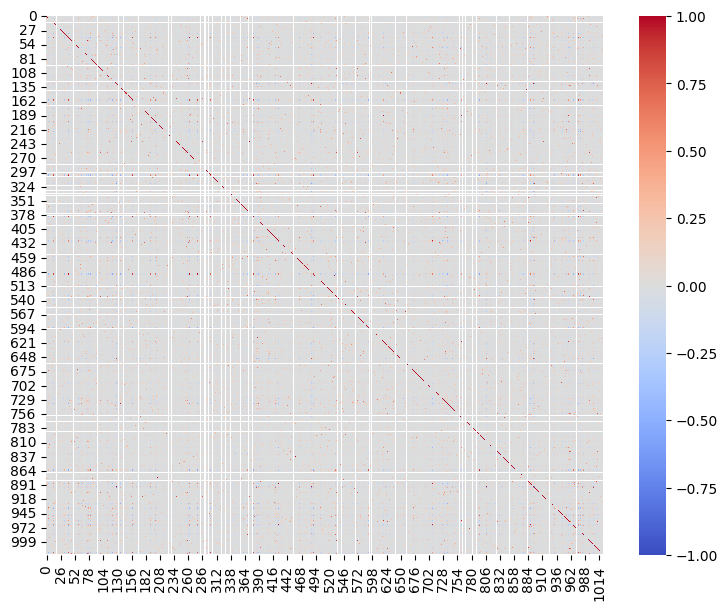

In [10]:
# Compute correlation matrix
fps_cor = X_fps_train.corr()

# Plot heatmap of correlations
plt.figure(figsize=(9, 7))
sns.heatmap(fps_cor, cmap="coolwarm",  vmin=-1, vmax=1, annot=False)
plt.savefig("./imgs/fps_corr.png", bbox_inches="tight")
plt.show()

### 1.3 EDA for Binding Affinity (Labels)

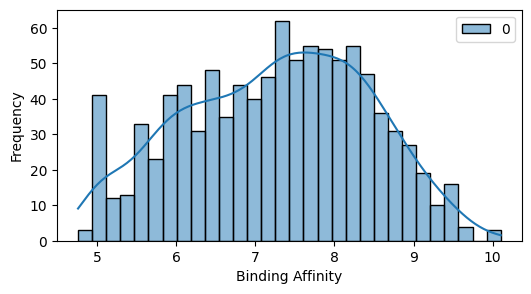

In [11]:
plt.figure(figsize=(6,3))
sns.histplot(y_train, bins=30, kde=True)
plt.xlabel("Binding Affinity")
plt.ylabel("Frequency")
# plt.title("Distribution of Binding Affinity (Target)")
plt.savefig("./imgs/target_dist.png", bbox_inches="tight")
plt.show()

## 2. Model Selection

In [12]:
# include
# Define a 5-fold cross-validation
KFCV=KFold(n_splits=5, shuffle=True, random_state=214)

In [13]:
# Models to try
models = ["Lasso", "Ridge", "KNN", "RF", "NN"]

Embed Features: Lasso Regressor

In [14]:
# Define pipeline for lasso regression
embed_lasso_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise the features
    ('pca', PCA(n_components=0.98)), # Keep 98% of variance
    ('box-cox transform', YeoJohnsonTransformer()), # Box-Cox transformation
    ('regressor', Lasso())  # Lasso Regression with L1 regularization
])

# Define the parameter grid for alpha tuning
embed_lasso_param_grid = {
    'regressor__alpha': np.logspace(-3, -1, num=20)
}

# Perform GridSearchCV with cross-validation
embed_lasso_grid_search = GridSearchCV(
    embed_lasso_pipeline,
    embed_lasso_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=-1
    )
embed_lasso_grid_search.fit(X_embed_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.98)),
                                       ('box-cox transform',
                                        YeoJohnsonTransformer()),
                                       ('regressor', Lasso())]),
             n_jobs=-1,
             param_grid={'regressor__alpha': array([0.001     , 0.00127427, 0.00162378, 0.00206914, 0.00263665,
       0.00335982, 0.00428133, 0.00545559, 0.00695193, 0.00885867,
       0.01128838, 0.0143845 , 0.01832981, 0.02335721, 0.02976351,
       0.0379269 , 0.0483293 , 0.06158482, 0.078476  , 0.1       ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [15]:
# Retrieve the best alpha value and model (refitted using 'neg_mean_squared_error')
embed_lasso_best_alpha = embed_lasso_grid_search.best_params_['regressor__alpha']
embed_lasso_best_model = embed_lasso_grid_search.best_estimator_

# Retrieve cross validation result
embed_lasso_cv_results = pd.DataFrame(embed_lasso_grid_search.cv_results_)
embed_lasso_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__alpha',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_regressor__alpha,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
10,0.011288,-0.863855,-0.737467
9,0.008859,-0.864440,-0.737605
11,0.014384,-0.865040,-0.738358
8,0.006952,-0.866492,-0.738508
12,0.018330,-0.868361,-0.740601
7,0.005456,-0.868767,-0.739232
6,0.004281,-0.871185,-0.739889
13,0.023357,-0.873080,-0.744370
5,0.003360,-0.873552,-0.740509
4,0.002637,-0.875498,-0.741038


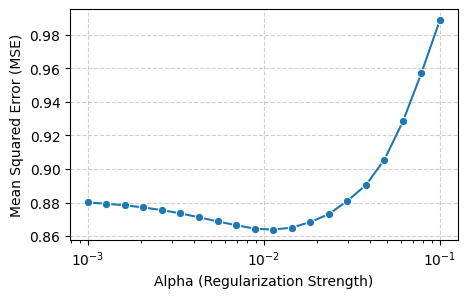

In [16]:
# Extract alpha values and corresponding MSE from Lasso CV results
lasso_alpha_mse = embed_lasso_cv_results[["param_regressor__alpha", "mean_test_neg_mean_squared_error"]].copy()
# Convert negative MSE to positive for correct interpretation
lasso_alpha_mse["mean_test_neg_mean_squared_error"] = -lasso_alpha_mse["mean_test_neg_mean_squared_error"]

# Plot MSE vs Alpha
plt.figure(figsize=(5, 3))
sns.lineplot(data=lasso_alpha_mse, x="param_regressor__alpha", y="mean_test_neg_mean_squared_error", marker="o")

plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("Lasso (for Embed Features): MSE vs Alpha")
plt.xscale("log")  # Use log scale for better visualization if alpha varies significantly
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("./imgs/embed_lasso_alpha.png", bbox_inches="tight")
plt.show()

Embed Features: Ridge Regressor

In [17]:
# Define pipeline for ridge regression
embed_ridge_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise the features
    ('pca', PCA(n_components=0.98)), # Keep 98% of variance
    ('box-cox transform', YeoJohnsonTransformer()), # Box-Cox transformation
    ('regressor', Ridge())  # Ridge Regression with L2 regularization
])

# Define the parameter grid for alpha tuning
embed_ridge_param_grid = {
    'regressor__alpha': np.linspace(150, 200, num=20)
}

# Perform GridSearchCV with cross-validation
embed_ridge_grid_search = GridSearchCV(
    embed_ridge_pipeline,
    embed_ridge_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=6
    )
embed_ridge_grid_search.fit(X_embed_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA(n_components=0.98)),
                                       ('box-cox transform',
                                        YeoJohnsonTransformer()),
                                       ('regressor', Ridge())]),
             n_jobs=6,
             param_grid={'regressor__alpha': array([150.        , 152.63157895, 155.26315789, 157.89473684,
       160.52631579, 163.15789474, 165.78947368, 168.42105263,
       171.05263158, 173.68421053, 176.31578947, 178.94736842,
       181.57894737, 184.21052632, 186.84210526, 189.47368421,
       192.10526316, 194.73684211, 197.36842105, 200.        ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [18]:
# Retrieve the best alpha value and model (refitted using 'neg_mean_squared_error')
embed_ridge_best_alpha = embed_ridge_grid_search.best_params_['regressor__alpha']
embed_ridge_best_model = embed_ridge_grid_search.best_estimator_

# Retrieve cross validation result
embed_ridge_cv_results = pd.DataFrame(embed_ridge_grid_search.cv_results_)
embed_ridge_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__alpha',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_regressor__alpha,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
6,165.789474,-0.843946,-0.731387
7,168.421053,-0.843949,-0.731417
5,163.157895,-0.843951,-0.731359
8,171.052632,-0.843958,-0.731453
4,160.526316,-0.843963,-0.731332
9,173.684211,-0.843974,-0.731490
3,157.894737,-0.843982,-0.731309
10,176.315789,-0.843996,-0.731527
2,155.263158,-0.844009,-0.731286
11,178.947368,-0.844024,-0.731577


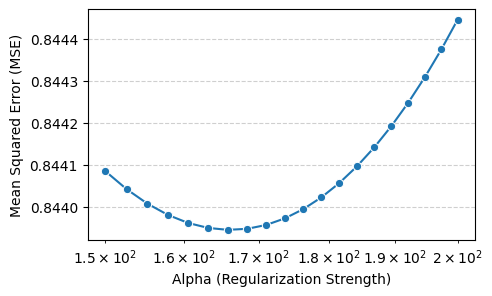

In [19]:
# Extract alpha values and corresponding MSE from Lasso CV results
embed_ridge_alpha_mse = embed_ridge_cv_results[["param_regressor__alpha", "mean_test_neg_mean_squared_error"]].copy()
# Convert negative MSE to positive for correct interpretation
embed_ridge_alpha_mse["mean_test_neg_mean_squared_error"] = -embed_ridge_alpha_mse["mean_test_neg_mean_squared_error"]

# Plot MSE vs Alpha
plt.figure(figsize=(5, 3))
sns.lineplot(data=embed_ridge_alpha_mse, x="param_regressor__alpha", y="mean_test_neg_mean_squared_error", marker="o")

plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("Ridge (for Embed Features): MSE vs Alpha")
plt.xscale("log")  # Use log scale for better visualization if alpha varies significantly
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("./imgs/embed_ridge_alpha.png", bbox_inches="tight")
plt.show()

Embed Features: KNN

In [20]:
# Define pipeline for ridge regression
embed_knn_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise the features
    ('pca', PCA()), # Proportion of variance explained to be choosed using CV results
    ('regressor', KNeighborsRegressor())  # KNN
])

# Define the parameter grid for alpha tuning
embed_knn_param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95, 0.98],
    'regressor__n_neighbors': np.arange(1, 11), # K neighbors
    'regressor__weights': ['uniform', 'distance']
}

# Perform GridSearchCV with cross-validation
embed_knn_grid_search = GridSearchCV(
    embed_knn_pipeline,
    embed_knn_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=6
    )
embed_knn_grid_search.fit(X_embed_train, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=6,
             param_grid={'pca__n_components': [0.85, 0.9, 0.95, 0.98],
                         'regressor__n_neighbors': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10]),
                         'regressor__weights': ['uniform', 'distance']},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [21]:
# Retrieve the best k value and model (refitted using 'neg_mean_squared_error')
embed_knn_best_k = embed_knn_grid_search.best_params_['regressor__n_neighbors']
embed_knn_best_model = embed_knn_grid_search.best_estimator_

# Retrieve cross validation result
embed_knn_cv_results = pd.DataFrame(embed_knn_grid_search.cv_results_)
embed_knn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__n_neighbors',
    'param_regressor__weights',
    'param_pca__n_components',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_regressor__n_neighbors,param_regressor__weights,param_pca__n_components,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
53,7,distance,0.95,-0.764000,-0.683484
69,5,distance,0.98,-0.764264,-0.674387
71,6,distance,0.98,-0.765735,-0.679159
73,7,distance,0.98,-0.771464,-0.682537
51,6,distance,0.95,-0.774016,-0.683425
33,7,distance,0.90,-0.774813,-0.684396
49,5,distance,0.95,-0.774827,-0.678542
31,6,distance,0.90,-0.776936,-0.681831
55,8,distance,0.95,-0.779125,-0.689499
68,5,uniform,0.98,-0.780416,-0.683215


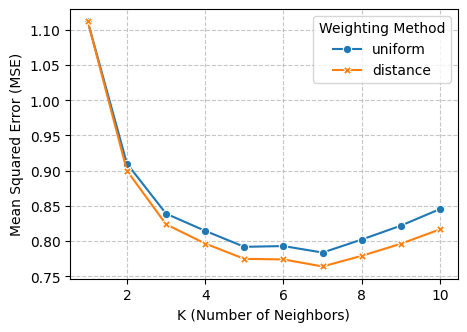

In [22]:
# Identify the best PCA proportion (based on lowest MSE)
embed_knn_best_pca_prop = embed_knn_cv_results.loc[
    embed_knn_cv_results['mean_test_neg_mean_squared_error'].idxmax(),
    'param_pca__n_components'
]

# Filter results to only include rows with that best PCA value
embed_knn_k_mse = embed_knn_cv_results[
    embed_knn_cv_results['param_pca__n_components'] == embed_knn_best_pca_prop
][[
    "param_regressor__n_neighbors",
    "param_regressor__weights",
    "mean_test_neg_mean_squared_error"
]].copy()

# Convert MSE to positive for interpretation
embed_knn_k_mse["mean_test_neg_mean_squared_error"] *= -1

# Plot MSE vs K, with different lines for 'uniform' and 'distance' weighting
plt.figure(figsize=(5, 3.5))
sns.lineplot(
    data=embed_knn_k_mse, 
    x="param_regressor__n_neighbors", 
    y="mean_test_neg_mean_squared_error",
    hue="param_regressor__weights",  # Differentiate uniform vs distance
    style="param_regressor__weights",
    markers=True,
    dashes=False
)

plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("KNN (for Embed Features): MSE vs Number of Neighbors")
plt.legend(title="Weighting Method")
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("./imgs/embed_knn_k.png", bbox_inches="tight")
plt.show()

Embed Features: Random Forest Regressor

In [23]:
# Define the pipeline for Random Forest
embed_rf_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise features
    ('pca', PCA()), # Proportion of variance explained to be choosed using CV results
    ('regressor', RandomForestRegressor(criterion='squared_error', random_state=214))  # Random forest regressor
])

# Define the parameter grid for hyperparameter tuning
embed_rf_param_grid = {
    'pca__n_components': [0.85, 0.9, 0.98],
    'regressor__n_estimators': [300, 400, 500],  # Number of trees
}

# Perform GridSearchCV with cross-validation
embed_rf_grid_search = GridSearchCV(
    embed_rf_pipeline,
    embed_rf_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=-1
)
embed_rf_grid_search.fit(X_embed_train, y_train.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('regressor',
                                        RandomForestRegressor(random_state=214))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [0.85, 0.9, 0.98],
                         'regressor__n_estimators': [300, 400, 500]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [24]:
# Retrieve the best parameters and model
embed_rf_best_params = embed_rf_grid_search.best_params_
embed_rf_best_model = embed_rf_grid_search.best_estimator_

# Retrieve cross-validation results
embed_rf_cv_results = pd.DataFrame(embed_rf_grid_search.cv_results_)
embed_rf_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__n_estimators',
     'param_pca__n_components',
     'mean_test_neg_mean_squared_error',
     'mean_test_neg_mean_absolute_error',
     ]].head(10)

,param_regressor__n_estimators,param_pca__n_components,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
4,400,0.90,-0.833200,-0.730295
3,300,0.90,-0.833205,-0.729987
5,500,0.90,-0.833438,-0.729975
2,500,0.85,-0.838901,-0.735380
0,300,0.85,-0.839898,-0.735540
1,400,0.85,-0.840469,-0.736546
8,500,0.98,-0.870948,-0.751151
7,400,0.98,-0.872027,-0.751588
6,300,0.98,-0.873401,-0.753025


Embed Features: NN Regressor

In [25]:
# Define pipeline for Neural Network
embed_nn_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise features
    ('pca', PCA()),  # Proportion of variance explained to be choosed using CV results
    ('regressor', MLPRegressor(solver='adam', max_iter=2000, early_stopping=True, random_state=214))  # Neural Network
])

# Define parameter grid for tuning
embed_nn_param_grid = {
    'pca__n_components': [0.85, 0.9, 0.98],
    'regressor__hidden_layer_sizes': [(64,), (128,), (128, 128,), (64, 128, 64)], # Hidden layer numbers and sizes
    'regressor__activation': ['relu', 'logistic'], # Activation functions
}

# Perform GridSearchCV with cross-validation
embed_nn_grid_search = GridSearchCV(
    embed_nn_pipeline,
    embed_nn_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=-1
)

# Fit the Neural Network model
embed_nn_grid_search.fit(X_embed_train, y_train.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('scaler', StandardScaler()),
                                       ('pca', PCA()),
                                       ('regressor',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=2000,
                                                     random_state=214))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [0.85, 0.9, 0.98],
                         'regressor__activation': ['relu', 'logistic'],
                         'regressor__hidden_layer_sizes': [(64,), (128,),
                                                           (128, 128),
                                                           (64, 128, 64)]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [26]:
# Retrieve best parameters and best model
embed_nn_best_params = embed_nn_grid_search.best_params_
embed_nn_best_model = embed_nn_grid_search.best_estimator_

# Retrieve cross-validation results
embed_nn_cv_results = pd.DataFrame(embed_nn_grid_search.cv_results_)
embed_nn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_pca__n_components',
    'param_regressor__hidden_layer_sizes',
    'param_regressor__activation',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_pca__n_components,param_regressor__hidden_layer_sizes,param_regressor__activation,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
4,0.85,"(64,)",logistic,-0.835146,-0.718434
12,0.90,"(64,)",logistic,-0.836687,-0.722659
13,0.90,"(128,)",logistic,-0.857095,-0.725176
15,0.90,"(64, 128, 64)",logistic,-0.859808,-0.727246
21,0.98,"(128,)",logistic,-0.864063,-0.734628
22,0.98,"(128, 128)",logistic,-0.876747,-0.747815
20,0.98,"(64,)",logistic,-0.879330,-0.741338
14,0.90,"(128, 128)",logistic,-0.889617,-0.750852
5,0.85,"(128,)",logistic,-0.910703,-0.758101
6,0.85,"(128, 128)",logistic,-0.913774,-0.763015


Fps Features: Lasso

In [27]:
fps_pca = PCA(n_components=0.95)
fps_scaler = StandardScaler()
X_fps_train_c = fps_scaler.fit(X_fps_train).transform(X_fps_train)
X_fps_pca_c = fps_pca.fit(X_fps_train_c).transform(X_fps_train_c)
print(f"Original number of features: {X_fps_train_c.shape[1]}")
print(f"Reduced number of features: {X_fps_pca_c.shape[1]}")
X_fps_pca_c = pd.DataFrame(X_fps_pca_c)

Original number of features: 1024
Reduced number of features: 410


In [28]:
# Define pipeline for lasso regression
fps_lasso_pipeline = Pipeline([
    ('box-cox transform', YeoJohnsonTransformer()), # Box-Cox transformation
    ('regressor', Lasso())  # Lasso Regression with L1 regularization
])

# Define the parameter grid for alpha tuning
fps_lasso_param_grid = {
    'regressor__alpha': np.logspace(-4, 1, 20)
}

# Perform GridSearchCV with cross-validation
fps_lasso_grid_search = GridSearchCV(
    fps_lasso_pipeline,
    fps_lasso_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error', 
    n_jobs= 5
    )
fps_lasso_grid_search.fit(X_fps_pca_c, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('box-cox transform',
                                        YeoJohnsonTransformer()),
                                       ('regressor', Lasso())]),
             n_jobs=5,
             param_grid={'regressor__alpha': array([1.00000000e-04, 1.83298071e-04, 3.35981829e-04, 6.15848211e-04,
       1.12883789e-03, 2.06913808e-03, 3.79269019e-03, 6.95192796e-03,
       1.27427499e-02, 2.33572147e-02, 4.28133240e-02, 7.84759970e-02,
       1.43844989e-01, 2.63665090e-01, 4.83293024e-01, 8.85866790e-01,
       1.62377674e+00, 2.97635144e+00, 5.45559478e+00, 1.00000000e+01])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [29]:
# Retrieve the best alpha value and model (refitted using 'neg_mean_squared_error')
fps_lasso_best_alpha = fps_lasso_grid_search.best_params_['regressor__alpha']
print(f'alpha = {fps_lasso_best_alpha}')
fps_lasso_best_regressor = fps_lasso_grid_search.best_estimator_

# Retrieve cross validation result
fps_lasso_cv_results = pd.DataFrame(fps_lasso_grid_search.cv_results_)
fps_lasso_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__alpha',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

alpha = 0.023357214690901212


,param_regressor__alpha,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
9,0.023357,-0.855098,-0.735410
10,0.042813,-0.865074,-0.757749
8,0.012743,-0.906257,-0.744455
11,0.078476,-0.920535,-0.792957
7,0.006952,-1.028725,-0.783634
12,0.143845,-1.042412,-0.846913
13,0.263665,-1.185155,-0.900445
6,0.003793,-1.219436,-0.837226
14,0.483293,-1.304817,-0.949886
15,0.885867,-1.355446,-0.970273


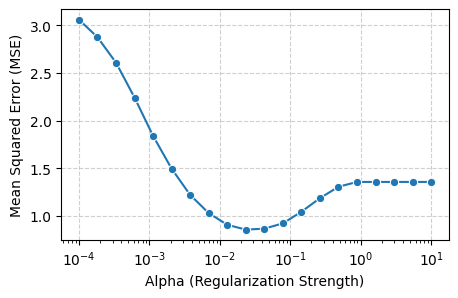

In [30]:
# Plot the mean test MSE and MAE against alpha
fps_lasso_alpha_mse = fps_lasso_cv_results[["param_regressor__alpha", "mean_test_neg_mean_squared_error"]].copy()
# Convert negative MSE to positive for correct interpretation
fps_lasso_alpha_mse["mean_test_neg_mean_squared_error"] = -fps_lasso_alpha_mse["mean_test_neg_mean_squared_error"]

plt.figure(figsize=(5, 3))
sns.lineplot(data=fps_lasso_alpha_mse, x="param_regressor__alpha", y="mean_test_neg_mean_squared_error", marker="o")

plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("Lasso (for Fps Features): MSE vs Alpha")
plt.xscale("log")  # Use log scale for better visualization if alpha varies significantly
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("./imgs/fps_lasso_alpha.png", bbox_inches="tight")
plt.show()

In [31]:
# Retrieve the coefficients from the best Lasso model
lasso_coefficients = fps_lasso_best_regressor.fit(X_fps_pca_c, y_train).named_steps['regressor'].coef_
# Count the number of non-zero coefficients
non_zero_coefficients = np.sum(lasso_coefficients != 0)

print(f"Number of non-zero coefficients in the best Lasso model: {non_zero_coefficients}")

Number of non-zero coefficients in the best Lasso model: 251


Fps Features: Ridge

In [32]:
# Define pipeline for ridge regression
fps_ridge_pipeline = Pipeline([
    ('box-cox transform', YeoJohnsonTransformer()), # Box-Cox transformation
    ('regressor', Ridge())  # Lasso Regression with L2 regularization
])

# Define the parameter grid for alpha tuning
fps_ridge_param_grid = {
    'regressor__alpha': np.logspace(-1, 4, 20)
}

# Perform GridSearchCV with cross-validation
fps_ridge_grid_search = GridSearchCV(
    fps_ridge_pipeline,
    fps_ridge_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error', 
    n_jobs= 5
    )
fps_ridge_grid_search.fit(X_fps_pca_c, y_train)

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('box-cox transform',
                                        YeoJohnsonTransformer()),
                                       ('regressor', Ridge())]),
             n_jobs=5,
             param_grid={'regressor__alpha': array([1.00000000e-01, 1.83298071e-01, 3.35981829e-01, 6.15848211e-01,
       1.12883789e+00, 2.06913808e+00, 3.79269019e+00, 6.95192796e+00,
       1.27427499e+01, 2.33572147e+01, 4.28133240e+01, 7.84759970e+01,
       1.43844989e+02, 2.63665090e+02, 4.83293024e+02, 8.85866790e+02,
       1.62377674e+03, 2.97635144e+03, 5.45559478e+03, 1.00000000e+04])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [33]:
# Retrieve the best alpha value and model (refitted using 'neg_mean_squared_error')
fps_ridge_best_alpha = fps_ridge_grid_search.best_params_['regressor__alpha']
print(f'alpha = {fps_ridge_best_alpha}')
fps_ridge_best_regressor = fps_ridge_grid_search.best_estimator_

# Retrieve cross validation result
fps_ridge_cv_results = pd.DataFrame(fps_ridge_grid_search.cv_results_)
fps_ridge_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__alpha',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

alpha = 885.8667904100823


,param_regressor__alpha,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
15,885.866790,-0.768402,-0.712987
14,483.293024,-0.774224,-0.706433
16,1623.776739,-0.807016,-0.739649
13,263.665090,-0.830002,-0.722348
17,2976.351442,-0.880864,-0.776577
12,143.844989,-0.939050,-0.759502
18,5455.594781,-0.976179,-0.820455
19,10000.000000,-1.075953,-0.863540
11,78.475997,-1.105228,-0.810593
10,42.813324,-1.334779,-0.867948


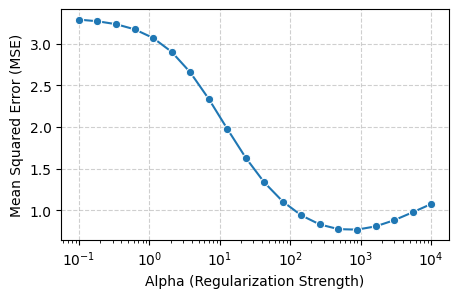

In [34]:
fps_ridge_alpha_mse = fps_ridge_cv_results[["param_regressor__alpha", "mean_test_neg_mean_squared_error"]].copy()
# Convert negative MSE to positive for correct interpretation
fps_ridge_alpha_mse["mean_test_neg_mean_squared_error"] = -fps_ridge_alpha_mse["mean_test_neg_mean_squared_error"]

plt.figure(figsize=(5, 3))
sns.lineplot(data=fps_ridge_alpha_mse, x="param_regressor__alpha", y="mean_test_neg_mean_squared_error", marker="o")

plt.xlabel("Alpha (Regularization Strength)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("Ridge (for Fps Features): MSE vs Alpha")
plt.xscale("log")  # Use log scale for better visualization if alpha varies significantly
plt.grid(True, linestyle="--", alpha=0.6)
plt.savefig("./imgs/fps_ridge_alpha.png", bbox_inches="tight")
plt.show()

Fps Features: KNN

In [35]:
fps_knn_pipeline = Pipeline([
    ('regressor', KNeighborsRegressor(metric='hamming')) 
])

fps_knn_param_grid = {
    'regressor__n_neighbors': np.arange(1, 10), # K neighbors
    'regressor__weights': ['uniform', 'distance']
}

# Perform GridSearchCV with cross-validation
fps_knn_grid_search = GridSearchCV(
    fps_knn_pipeline,
    fps_knn_param_grid,
    cv = KFCV, 
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error', 
    n_jobs=-1
)
fps_knn_grid_search.fit(X_fps_train, y_train.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('regressor',
                                        KNeighborsRegressor(metric='hamming'))]),
             n_jobs=-1,
             param_grid={'regressor__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'regressor__weights': ['uniform', 'distance']},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [36]:
# Retrieve the best k value and model (refitted using 'neg_mean_squared_error')
fps_knn_best_k = fps_knn_grid_search.best_params_['regressor__n_neighbors']
print(f'K = {fps_knn_best_k}')
fps_knn_best_model = fps_knn_grid_search.best_estimator_

# Retrieve cross validation result
fps_knn_cv_results = pd.DataFrame(fps_knn_grid_search.cv_results_)
fps_knn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__weights',
    'param_regressor__n_neighbors',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)


K = 5


,param_regressor__weights,param_regressor__n_neighbors,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
9,distance,5,-0.626558,-0.594101
13,distance,7,-0.627262,-0.598016
11,distance,6,-0.635274,-0.599311
15,distance,8,-0.635572,-0.603040
7,distance,4,-0.637400,-0.596436
17,distance,9,-0.641176,-0.606682
8,uniform,5,-0.666066,-0.617968
12,uniform,7,-0.670298,-0.622526
6,uniform,4,-0.670430,-0.618060
5,distance,3,-0.671894,-0.612292


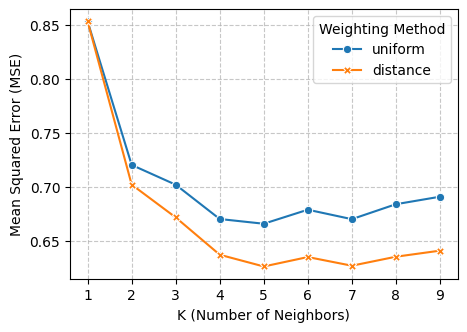

In [37]:
# Extract k values and corresponding MSE from CV results
fps_knn_cv_mse = fps_knn_cv_results[["param_regressor__n_neighbors", "param_regressor__weights", "mean_test_neg_mean_squared_error"]].copy()
# Convert negative MSE to positive for correct interpretation
fps_knn_cv_mse["mean_test_neg_mean_squared_error"] = -fps_knn_cv_mse["mean_test_neg_mean_squared_error"]

# Plot MSE vs K, with different lines for 'uniform' and 'distance' weighting
plt.figure(figsize=(5, 3.5))
sns.lineplot(
    data=fps_knn_cv_mse,
    x="param_regressor__n_neighbors", 
    y="mean_test_neg_mean_squared_error",
    hue="param_regressor__weights",  # Differentiate uniform vs distance
    style="param_regressor__weights",
    markers=True,
    dashes=False
)

plt.xlabel("K (Number of Neighbors)")
plt.ylabel("Mean Squared Error (MSE)")
# plt.title("KNN (for Fps Features): MSE vs Number of Neighbors")
plt.legend(title="Weighting Method")
plt.grid(True, linestyle="--", alpha=0.7)
plt.savefig("./imgs/fps_knn_k.png", bbox_inches="tight")
plt.show()

Fps Features: Random Forest

In [38]:
# Define the pipeline for Random Forest
fps_rf_pipeline = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('standardizer', StandardScaler()), 
    ('pca', PCA()), 
    ('regressor', RandomForestRegressor(criterion='squared_error', random_state=214))  # Random forest regressor
])

# Define the parameter grid for hyperparameter tuning
fps_rf_param_grid = {
    'pca__n_components': [0.85, 0.9, 0.95],
    'regressor__n_estimators': [100, 200, 300],  # Number of trees
}

# Perform GridSearchCV with cross-validation
fps_rf_grid_search = GridSearchCV(
    fps_rf_pipeline,
    fps_rf_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error', 
    n_jobs=-1
)
fps_rf_grid_search.fit(X_fps_train, y_train.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('feature_selection',
                                        VarianceThreshold(threshold=0)),
                                       ('standardizer', StandardScaler()),
                                       ('pca', PCA()),
                                       ('regressor',
                                        RandomForestRegressor(random_state=214))]),
             n_jobs=-1,
             param_grid={'pca__n_components': [0.85, 0.9, 0.95],
                         'regressor__n_estimators': [100, 200, 300]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [39]:
# Retrieve the best parameters and model
fps_rf_best_params = fps_rf_grid_search.best_params_
fps_rf_best_model = fps_rf_grid_search.best_estimator_

# Retrieve cross-validation results
fps_rf_cv_results = pd.DataFrame(fps_rf_grid_search.cv_results_)
fps_rf_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__n_estimators',
    'param_pca__n_components',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_regressor__n_estimators,param_pca__n_components,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
1,200,0.85,-0.855701,-0.748117
2,300,0.85,-0.857419,-0.748323
4,200,0.90,-0.861747,-0.752627
5,300,0.90,-0.862243,-0.751065
0,100,0.85,-0.867507,-0.752784
7,200,0.95,-0.870252,-0.759563
8,300,0.95,-0.871153,-0.758217
3,100,0.90,-0.872077,-0.757012
6,100,0.95,-0.874164,-0.761037


Fps Features: NN

In [40]:
# Define pipeline for Neural Network
fps_nn_pipeline = Pipeline([
    ('regressor', MLPRegressor(solver='adam', max_iter=2000, early_stopping=True, random_state=214))  # Neural Network
])

# Define parameter grid for tuning
fps_nn_param_grid = {
    'regressor__hidden_layer_sizes': [(64,), (128,), (128, 128,), (64, 128, 64)], # Hidden layer numbers and sizes
    'regressor__activation': ['relu', 'logistic'], # Activation functions
}

# Perform GridSearchCV with cross-validation
fps_nn_grid_search = GridSearchCV(
    fps_nn_pipeline,
    fps_nn_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=-1
)
fps_nn_grid_search.fit(X_fps_pca_c, y_train.ravel())

GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('regressor',
                                        MLPRegressor(early_stopping=True,
                                                     max_iter=2000,
                                                     random_state=214))]),
             n_jobs=-1,
             param_grid={'regressor__activation': ['relu', 'logistic'],
                         'regressor__hidden_layer_sizes': [(64,), (128,),
                                                           (128, 128),
                                                           (64, 128, 64)]},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [41]:
# Retrieve the best model
fps_nn_best_model = fps_nn_grid_search.best_estimator_

# Retrieve cross-validation results
fps_nn_cv_results = pd.DataFrame(fps_nn_grid_search.cv_results_)
fps_nn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_regressor__hidden_layer_sizes',
    'param_regressor__activation',
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_regressor__hidden_layer_sizes,param_regressor__activation,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
6,"(128, 128)",logistic,-0.835289,-0.737219
7,"(64, 128, 64)",logistic,-1.022628,-0.809590
2,"(128, 128)",relu,-2.333387,-1.129428
5,"(128,)",logistic,-2.412623,-1.102141
3,"(64, 128, 64)",relu,-2.762412,-1.175329
4,"(64,)",logistic,-3.601441,-1.349134
1,"(128,)",relu,-6.534066,-1.885996
0,"(64,)",relu,-9.252612,-2.280009


### 2.1 Embed Features: Model Selection

In [42]:
# Extract top results from CV results for each model
embed_cv_results_sorted = {
    "Lasso": embed_lasso_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "Ridge": embed_ridge_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "KNN": embed_knn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "Random Forest": embed_rf_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "Neural Network": embed_nn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
}
# Convert to a readable dataframe
embed_cv_summary = pd.concat(embed_cv_results_sorted, axis=0)
embed_cv_summary.index = models # reindex

# Extract mean MSE and standard deviation from CV results
embed_mean_mse = -embed_cv_summary["mean_test_neg_mean_squared_error"].values  # Convert to positive MSE

# Compute 95% confidence intervals
embed_ci = 1.96 * (embed_cv_summary["std_test_neg_mean_squared_error"].values / np.sqrt(5))

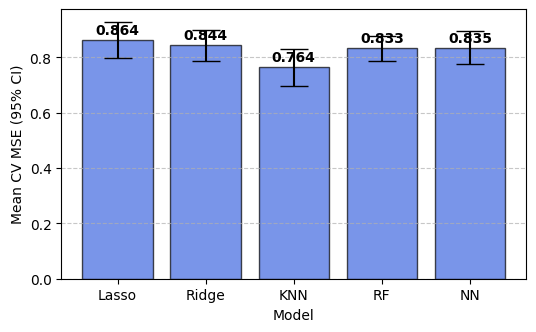

In [43]:
# CV Results Plot
plt.figure(figsize=(6, 3.5))
plt.bar(models, embed_mean_mse, yerr=embed_ci, capsize=10, color='royalblue', alpha=0.7, edgecolor='black')
plt.xlabel("Model")
plt.ylabel("Mean CV MSE (95% CI)")
# plt.title("Cross-Validation Performance Comparison for Embed Models")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add MSE values on top of bars
for i, v in enumerate(embed_mean_mse):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig("./imgs/embed_mse.png", bbox_inches="tight")
plt.show()

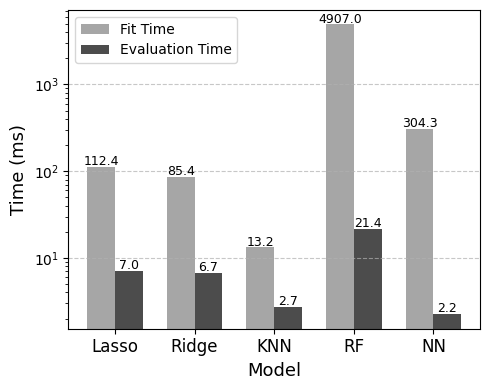

In [44]:
embed_mean_fit_time = embed_cv_summary["mean_fit_time"].values * 1000  # Convert to ms
embed_mean_score_time = embed_cv_summary["mean_score_time"].values * 1000  # Convert to ms

# Plot
bar_width = 0.35
x = np.arange(len(models))
plt.figure(figsize=(5, 4))
bars1 = plt.bar(x - bar_width/2, embed_mean_fit_time, width=bar_width, label="Fit Time", color='gray', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, embed_mean_score_time, width=bar_width, label="Evaluation Time", color='black', alpha=0.7)

# Add value annotations
for i in range(len(models)):
    plt.text(x[i] - bar_width/2, embed_mean_fit_time[i] * 1.05, f"{embed_mean_fit_time[i]:.1f}", ha='center', fontsize=9)
    plt.text(x[i] + bar_width/2, embed_mean_score_time[i] * 1.05, f"{embed_mean_score_time[i]:.1f}", ha='center', fontsize=9)

# Customize axes
plt.xticks(x, models, fontsize=12)
plt.xlabel("Model", fontsize=13)
plt.ylabel("Time (ms)", fontsize=13)
plt.legend()
plt.yscale("log")  # Log scale for interpretability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./imgs/embed_computation_times.png", bbox_inches="tight")
plt.show()

### 2.2 fps Features: Model Selection

In [45]:
# Extract top results from CV results for each model
fps_cv_results_sorted = {
    "Lasso": fps_lasso_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "Ridge": fps_ridge_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "KNN" : fps_knn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1), 
    "Random Forest": fps_rf_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1),
    "Neural Network": fps_nn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False).head(1)
}
# Convert to a readable dataframe
fps_cv_summary = pd.concat(fps_cv_results_sorted, axis=0)
fps_cv_summary.index = models # reindex

fps_mean_mse = -fps_cv_summary["mean_test_neg_mean_squared_error"].values  # Convert to positive MSE

# Compute 95% confidence intervals
fps_ci = 1.96 * (fps_cv_summary["std_test_neg_mean_squared_error"].values / np.sqrt(5))

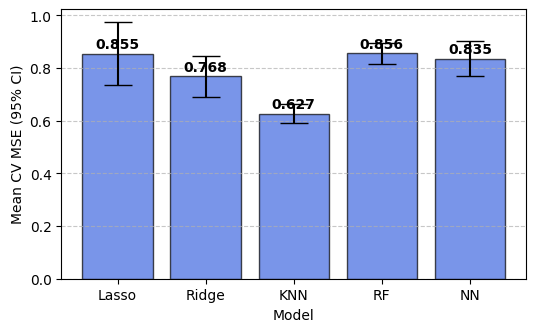

In [46]:
# CV Results Plot
plt.figure(figsize=(6, 3.5))
plt.bar(models, fps_mean_mse, yerr=fps_ci, capsize=10, color='royalblue', alpha=0.7, edgecolor='black')
plt.xlabel("Model")
plt.ylabel("Mean CV MSE (95% CI)")
# plt.title("Cross-Validation Performance Comparison for Fps Models")
plt.xticks(rotation=0)
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Add MSE values on top of bars
for i, v in enumerate(fps_mean_mse):
    plt.text(i, v + 0.01, f"{v:.3f}", ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.savefig("./imgs/fps_mse.png", bbox_inches="tight")
plt.show()

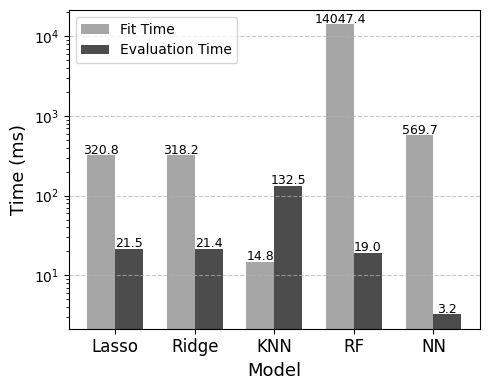

In [47]:
fps_mean_fit_time = fps_cv_summary["mean_fit_time"].values * 1000  # Convert to ms
fps_mean_score_time = fps_cv_summary["mean_score_time"].values * 1000  # Convert to ms

# Plot
bar_width = 0.35
x = np.arange(len(models))
plt.figure(figsize=(5, 4))
bars1 = plt.bar(x - bar_width/2, fps_mean_fit_time, width=bar_width, label="Fit Time", color='gray', alpha=0.7)
bars2 = plt.bar(x + bar_width/2, fps_mean_score_time, width=bar_width, label="Evaluation Time", color='black', alpha=0.7)

# Add value annotations
for i in range(len(models)):
    plt.text(x[i] - bar_width/2, fps_mean_fit_time[i] * 1.05, f"{fps_mean_fit_time[i]:.1f}", ha='center', fontsize=9)
    plt.text(x[i] + bar_width/2, fps_mean_score_time[i] * 1.05, f"{fps_mean_score_time[i]:.1f}", ha='center', fontsize=9)

# Customize axes
plt.xticks(x, models, fontsize=12)
plt.xlabel("Model", fontsize=13)
plt.ylabel("Time (ms)", fontsize=13)
plt.legend()
plt.yscale("log")  # Log scale for interpretability
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.savefig("./imgs/fps_computation_times.png", bbox_inches="tight")


### 2.3 Analysis of Performance

#### 2.3.1 Embed Features: Analysis of Performance

MSE: 0.7457145778191213
MAE: 0.7057861726048131


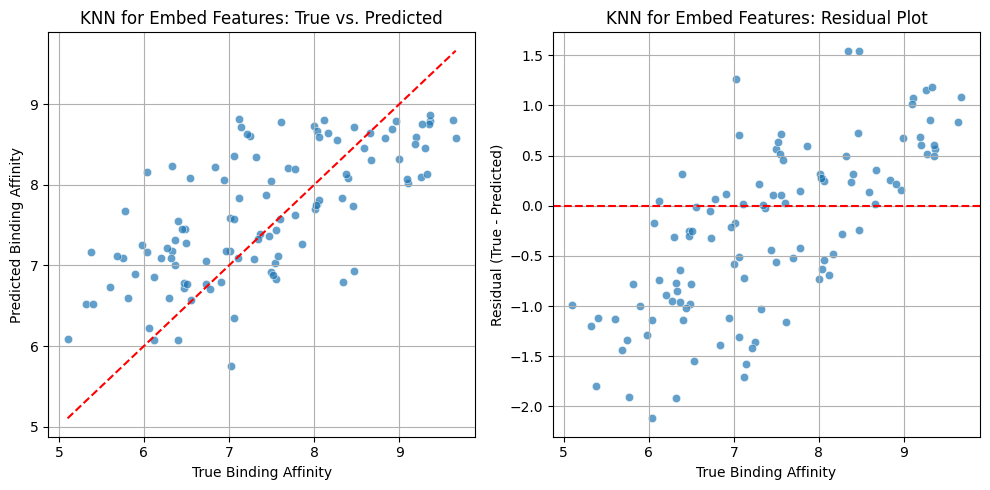

In [48]:
# Predict using KNN Regression on the public test set and obtain scorings
embed_y_pred_knn = embed_knn_best_model.predict(X_embed_public_test).ravel()
print(f'MSE: {mean_squared_error(y_public_test, embed_y_pred_knn)}')
print(f'MAE: {mean_absolute_error(y_public_test, embed_y_pred_knn)}')
# Convert y_public_test to a NumPy array (drop index column)
y_true = y_public_test.values.ravel()
# Compute residuals
embed_knn_residuals = y_true - embed_y_pred_knn

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- True vs. Predicted Plot ---
sns.scatterplot(x=y_true, y=embed_y_pred_knn, alpha=0.7, ax=axes[0])
axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle="--", color="red")  # Ideal prediction line
axes[0].set_xlabel("True Binding Affinity")
axes[0].set_ylabel("Predicted Binding Affinity")
axes[0].set_title("KNN for Embed Features: True vs. Predicted")
axes[0].grid(True)

# --- Residual Scatter Plot ---
sns.scatterplot(x=y_true, y=embed_knn_residuals, alpha=0.7, ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("True Binding Affinity")
axes[1].set_ylabel("Residual (True - Predicted)")
axes[1].set_title("KNN for Embed Features: Residual Plot")
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("./imgs/embed_knn_performance.png", bbox_inches="tight")
plt.show()

#### 2.3.2 Fps Features: Analysis of Performance

MSE: 0.8248692012671863
MAE: 0.7437406889959682


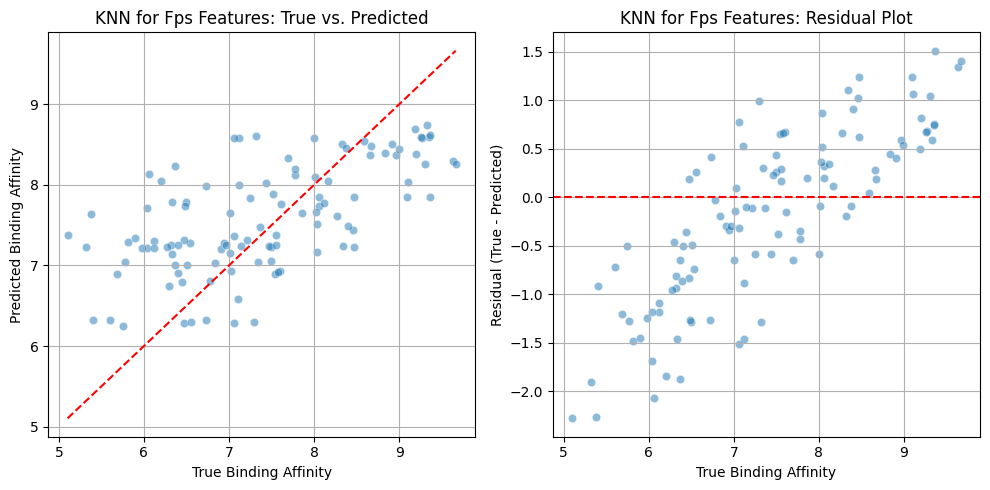

In [49]:
# Predict using KNN Regression on the public test set and obtain scorings
fps_y_pred_knn = fps_knn_best_model.predict(X_fps_public_test).ravel()
print(f'MSE: {mean_squared_error(y_public_test, fps_y_pred_knn)}')
print(f'MAE: {mean_absolute_error(y_public_test, fps_y_pred_knn)}')
# Convert y_public_test to a NumPy array (drop index column)
y_true = y_public_test.values.ravel()
# Compute residuals
fps_residuals_knn = y_true - fps_y_pred_knn

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- True vs. Predicted Plot ---
sns.scatterplot(x=y_true, y=fps_y_pred_knn, alpha=0.5, ax=axes[0])
axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle="--", color="red")  # Ideal prediction line
axes[0].set_xlabel("True Binding Affinity")
axes[0].set_ylabel("Predicted Binding Affinity")
axes[0].set_title("KNN for Fps Features: True vs. Predicted")
axes[0].grid(True)

# --- Residual Scatter Plot ---
sns.scatterplot(x=y_true, y=fps_residuals_knn, alpha=0.5, ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("True Binding Affinity")
axes[1].set_ylabel("Residual (True - Predicted)")
axes[1].set_title("KNN for Fps Features: Residual Plot")
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("./imgs/fps_knn_performance.png", bbox_inches="tight")
plt.show()

## 3. Combined Model

In [50]:
# include
# Append FPS features to Embed features (column-wise)
X_combined_train = pd.concat([X_embed_train, X_fps_train], axis=1).to_numpy()
X_combined_public_test = pd.concat([X_embed_public_test, X_fps_public_test], axis=1).to_numpy()
X_combined_private_test = pd.concat([X_embed_private_test, X_fps_private_test], axis=1).to_numpy()

KNN

In [51]:
# Re-define preprocessing for embed features (remove box-cox transformation)
embed_preprocessing = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalize embed features
    ('pca', PCA())  # Reduce dimensions while keeping 95% variance
])

# Re-define preprocessing for fps features
fps_preprocessing = Pipeline([
    ('pca', PCA())  # Reduce dimensions while keeping 95% variance
])
# fps_preprocessing = 'passthrough'

# Re-define ColumnTransformer
full_preprocessing = ColumnTransformer([
    ('embed_processing', embed_preprocessing, list(range(X_embed_train.shape[1]))),  # Process only embed features
    ('fps_processing', fps_preprocessing, list(range(X_embed_train.shape[1], X_combined_train.shape[1])))  # Leave fps features unchanged
])  # Leave fps features unchanged

# Define full pipeline
combined_knn_pipeline = Pipeline([
    ('preprocessing', full_preprocessing),  # Apply preprocessing
    ('regressor', KNeighborsRegressor())  # KNN
])

# Define hyperparameter grid
combined_knn_param_grid = {
    'preprocessing__embed_processing__pca__n_components': [0.95, 0.98],  # PCA for embed
    'preprocessing__fps_processing__pca__n_components': [0.95],  # PCA for fps
    'regressor__n_neighbors': np.arange(1, 10),
    'regressor__weights': ['uniform', 'distance']
}

# Perform GridSearchCV with cross-validation
combined_knn_grid_search = GridSearchCV(
    combined_knn_pipeline,
    combined_knn_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error',
    n_jobs=-1
)
combined_knn_grid_search.fit(X_combined_train, y_train)

/Users/yuanhao/LocalDoc/sml_practical/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('embed_processing',
                                                                         Pipeline(steps=[('feature_selection',
                                                                                          VarianceThreshold(threshold=0)),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20,
                                                                          21,
                                                                          22,
                                                                          23,
                                                                          24,
                                                                          25,
                                                                          26,
                                                                          27,
                                                                          28,...
                                       ('regressor', KNeighborsRegressor())]),
             n_jobs=-1,
             param_grid={'preprocessing__embed_processing__pca__n_components': [0.95,
                                                                                0.98],
                         'preprocessing__fps_processing__pca__n_components': [0.95],
                         'regressor__n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9]),
                         'regressor__weights': ['uniform', 'distance']},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [52]:
# Retrieve best hyperparameters and model
combined_knn_best_model = combined_knn_grid_search.best_estimator_

# Retrieve cross-validation results
combined_knn_cv_results = pd.DataFrame(combined_knn_grid_search.cv_results_)
combined_knn_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_preprocessing__embed_processing__pca__n_components',
    'param_preprocessing__fps_processing__pca__n_components',
    'param_regressor__n_neighbors',
    'param_regressor__weights', 
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_preprocessing__embed_processing__pca__n_components,param_preprocessing__fps_processing__pca__n_components,param_regressor__n_neighbors,param_regressor__weights,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
27,0.98,0.95,5,distance,-0.692240,-0.642903
29,0.98,0.95,6,distance,-0.694142,-0.644343
7,0.95,0.95,4,distance,-0.694150,-0.638267
25,0.98,0.95,4,distance,-0.698627,-0.641105
31,0.98,0.95,7,distance,-0.699087,-0.644510
11,0.95,0.95,6,distance,-0.699188,-0.646565
9,0.95,0.95,5,distance,-0.701522,-0.644825
13,0.95,0.95,7,distance,-0.701732,-0.646505
23,0.98,0.95,3,distance,-0.702197,-0.637494
26,0.98,0.95,5,uniform,-0.710402,-0.652634


In [53]:
combined_knn_y_pred = combined_knn_best_model.predict(X_combined_public_test)
mean_squared_error(y_public_test, combined_knn_y_pred)

0.8403655287248998

Elastic Net

In [54]:
# include
# Define preprocessing for embed features
embed_preprocessing = Pipeline([
    ('feature_selection', VarianceThreshold(threshold=0)),  # Remove constant features
    ('scaler', StandardScaler()),  # Normalise embed features
    ('pca', PCA()),  # PCA to reduce dimensions
    ('box-cox transform', YeoJohnsonTransformer()), # Box-Cox transformation
])

# Define preprocessing for fps features
fps_preprocessing = Pipeline([
    ('scaler', StandardScaler()),  # Normalize embed features
    ('pca', PCA()),  # PCA to Reduce dimensions
    ('box-cox transform', YeoJohnsonTransformer()), # Yeo-Johnson (Extended Box-Cox) transformation
])

# Combine preprocessing for embed and fps
combined_preprocessing = ColumnTransformer([
    ('embed_processing', embed_preprocessing, list(range(X_embed_train.shape[1]))),  # Process only for embed features
    ('fps_processing', fps_preprocessing, list(range(X_embed_train.shape[1], X_combined_train.shape[1])))  # Process only for fps features
])

# Define full pipeline
combined_elasticnet_pipeline = Pipeline([
    ('preprocessing', combined_preprocessing),  # Apply preprocessing
    ('regressor', ElasticNet())  # Elastic Net Regression
])

# Define hyperparameter grid
combined_elasticnet_param_grid = {
    'preprocessing__embed_processing__pca__n_components': [0.95, 0.98],  # PCA for embed
    'preprocessing__fps_processing__pca__n_components': [0.95, 0.98],  # PCA for fps
    'regressor__alpha': np.logspace(-1, 0, 5),  # Regularisation strength
    'regressor__l1_ratio': np.linspace(0.02, 0.1, 5)  # Balance between L1 and L2 penalty
}

# Perform GridSearchCV with cross-validation
combined_elasticnet_grid_search = GridSearchCV(
    combined_elasticnet_pipeline,
    combined_elasticnet_param_grid,
    cv=KFCV,
    scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'],
    refit='neg_mean_squared_error', # Use MSE to refit the model
    n_jobs=-1   # Using all processors to run faster
)
# Fit the model
combined_elasticnet_grid_search.fit(X_combined_train, y_train)

/Users/yuanhao/LocalDoc/sml_practical/.venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=KFold(n_splits=5, random_state=214, shuffle=True),
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(transformers=[('embed_processing',
                                                                         Pipeline(steps=[('feature_selection',
                                                                                          VarianceThreshold(threshold=0)),
                                                                                         ('scaler',
                                                                                          StandardScaler()),
                                                                                         ('pca',
                                                                                          PCA()),
                                                                                         ('box-cox '
                                                                                          'transform',
                                                                                          YeoJohnsonTransformer())]),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4, 5,
                                                                          6, 7,
                                                                          8, 9,
                                                                          10,
                                                                          11,
                                                                          12,
                                                                          1...
             param_grid={'preprocessing__embed_processing__pca__n_components': [0.95,
                                                                                0.98],
                         'preprocessing__fps_processing__pca__n_components': [0.95,
                                                                              0.98],
                         'regressor__alpha': array([0.1       , 0.17782794, 0.31622777, 0.56234133, 1.        ]),
                         'regressor__l1_ratio': array([0.02, 0.04, 0.06, 0.08, 0.1 ])},
             refit='neg_mean_squared_error',
             scoring=['neg_mean_squared_error', 'neg_mean_absolute_error'])

In [55]:
# include
# Retrieve best hyperparameters and model
combined_elasticnet_best_model = combined_elasticnet_grid_search.best_estimator_

# Retrieve cross-validation results
combined_elasticnet_cv_results = pd.DataFrame(combined_elasticnet_grid_search.cv_results_)
# Top 10 cross-validation results, with scores and best chosen parameters
combined_elasticnet_cv_results.sort_values('mean_test_neg_mean_squared_error', ascending=False)[[
    'param_preprocessing__embed_processing__pca__n_components',
    'param_preprocessing__fps_processing__pca__n_components',
    'param_regressor__alpha',
    'param_regressor__l1_ratio', 
    'mean_test_neg_mean_squared_error',
    'mean_test_neg_mean_absolute_error'
    ]].head(10)

,param_preprocessing__embed_processing__pca__n_components,param_preprocessing__fps_processing__pca__n_components,param_regressor__alpha,param_regressor__l1_ratio,mean_test_neg_mean_squared_error,mean_test_neg_mean_absolute_error
90,0.98,0.98,0.562341,0.02,-0.675454,-0.662482
40,0.95,0.98,0.562341,0.02,-0.675568,-0.662420
86,0.98,0.98,0.316228,0.04,-0.679198,-0.661847
36,0.95,0.98,0.316228,0.04,-0.679223,-0.661671
87,0.98,0.98,0.316228,0.06,-0.681001,-0.666138
65,0.98,0.95,0.562341,0.02,-0.681040,-0.666761
37,0.95,0.98,0.316228,0.06,-0.681163,-0.666200
15,0.95,0.95,0.562341,0.02,-0.681224,-0.666723
84,0.98,0.98,0.177828,0.10,-0.682974,-0.664313
34,0.95,0.98,0.177828,0.10,-0.683189,-0.664279


MSE: 0.6826597611928498
MAE: 0.6592956537237761


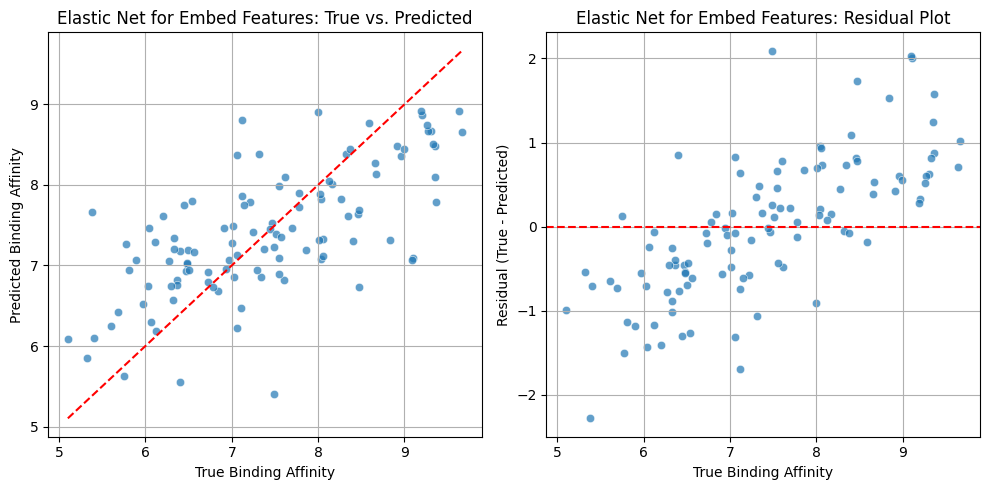

In [56]:
combined_elastic_y_pred = combined_elasticnet_best_model.predict(X_combined_public_test)
print(f'MSE: {mean_squared_error(y_public_test, combined_elastic_y_pred)}')
print(f'MAE: {mean_absolute_error(y_public_test, combined_elastic_y_pred)}')
# Convert y_public_test to a NumPy array (drop index column)
y_true = y_public_test.values.ravel()
# Compute residuals
residuals_elastic = y_true - combined_elastic_y_pred

# Create a figure with 4 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# --- True vs. Predicted Plot ---
sns.scatterplot(x=y_true, y=combined_elastic_y_pred, alpha=0.7, ax=axes[0])
axes[0].plot([min(y_true), max(y_true)], [min(y_true), max(y_true)], linestyle="--", color="red")  # Ideal prediction line
axes[0].set_xlabel("True Binding Affinity")
axes[0].set_ylabel("Predicted Binding Affinity")
axes[0].set_title("Elastic Net for Embed Features: True vs. Predicted")
axes[0].grid(True)

# --- Residual Scatter Plot ---
sns.scatterplot(x=y_true, y=residuals_elastic, alpha=0.7, ax=axes[1])
axes[1].axhline(y=0, color='red', linestyle='--')
axes[1].set_xlabel("True Binding Affinity")
axes[1].set_ylabel("Residual (True - Predicted)")
axes[1].set_title("Elastic Net for Embed Features: Residual Plot")
axes[1].grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.savefig("./imgs/combined_elastic_performance.png", bbox_inches="tight")
plt.show()

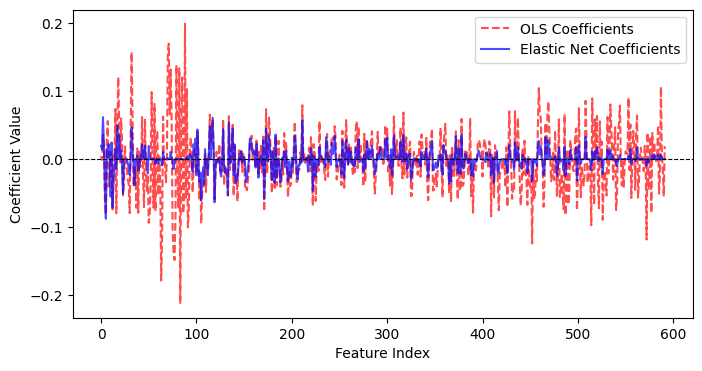

In [57]:
X_combined_train_transformed = combined_elasticnet_best_model[:-1].transform(X_combined_train)
ols_model = LinearRegression()
ols_model.fit(X_combined_train_transformed, y_train)
ols_coeffs = ols_model.coef_.flatten()

# Get Elastic Net coefficients (from best model in GridSearchCV)
elastic_coeffs = combined_elasticnet_best_model.named_steps['regressor'].coef_.flatten()

# Sort coefficients by absolute magnitude for better visualization
# sorted_indices = np.argsort(np.abs(ols_coeffs))[::-1]  # Sort by importance

# Plot coefficient comparison
plt.figure(figsize=(8, 4))
plt.plot(ols_coeffs, 'r--', label="OLS Coefficients", alpha=0.7)
plt.plot(elastic_coeffs, 'b-', label="Elastic Net Coefficients", alpha=0.7)
plt.axhline(0, color='black', linewidth=0.8, linestyle="--")
plt.xlabel("Feature Index")
plt.ylabel("Coefficient Value")
# plt.title("Effect of Elastic Net Regularization on Coefficients")
plt.legend()
plt.savefig("./imgs/combined_elastic-params.png", bbox_inches="tight")
plt.show()

### Anslysis of Performance

In [58]:
# include
# Performance on public test dataset
combined_elastic_y_pred = combined_elasticnet_best_model.predict(X_combined_public_test)
print(f'MSE on public test: {mean_squared_error(y_public_test, combined_elastic_y_pred)}')
print(f'MAE on public test: {mean_absolute_error(y_public_test, combined_elastic_y_pred)}')

MSE on public test: 0.6826597611928498
MAE on public test: 0.6592956537237761


In [59]:
# include
# CV MSE results
expected_mse_private = -combined_elasticnet_grid_search.best_score_
# Extract standard deviation of test MSE across folds for the best model
std_mse_private = combined_elasticnet_grid_search.cv_results_[
    'std_test_neg_mean_squared_error'
    ][combined_elasticnet_grid_search.best_index_]

# Compute 95% confidence interval
z = norm.ppf(0.975)
ci_lower = expected_mse_private - z * (std_mse_private / np.sqrt(5))
ci_upper = expected_mse_private + z * (std_mse_private / np.sqrt(5))

# Print expected MSE and confidence interval
print(f"Expected MSE on private set: {expected_mse_private:.3f} [{ci_lower:.3f}, {ci_upper:.3f}]")

Expected MSE on private set: 0.675 [0.616, 0.735]


In [60]:
# include
# Test MSE bootstrapping
# convert to 1D arrays
y_test_combined = y_public_test.squeeze()
def mse_stat(sample_indices):
    # Compute the MSE for each sample_indices
    return mean_squared_error(y_test_combined[sample_indices], combined_elastic_y_pred[sample_indices])

# Apply bootstrap (95% confidence interval)
res = bootstrap((np.arange(len(y_public_test)),), mse_stat, n_resamples=1000, method='basic', rng=412)

# Print estimated test MSE and CI
print(f"Bootstrap Estimated Test MSE: {res.bootstrap_distribution.mean():.3f}")
print(f"95% Confidence Interval using Bootstrap: ({res.confidence_interval.low:.3f}, {res.confidence_interval.high:.3f})")

Bootstrap Estimated Test MSE: 0.682
95% Confidence Interval using Bootstrap: (0.499, 0.859)


# Export in csv format

In [61]:
# include
# Export the predictions on the test data in csv format
private_pred = combined_elasticnet_best_model.predict(X_combined_private_test)
prediction = pd.DataFrame(private_pred, columns=['Prediction'])
prediction.index.name='Id'
prediction.to_csv('myprediction.csv') # export to csv file

In [62]:
# The following code output pure python scripts
import json

with open('report.ipynb', "r", encoding="utf-8") as f:
    notebook = json.load(f)

# Extract and process code cells starting with '# include'
code_cells = []
for cell in notebook["cells"]:
    if cell["cell_type"] == "code" and cell["source"]:
        first_line = cell["source"][0].strip()
        if first_line.startswith("# include"):
            # Exclude the first line from output
            code_cells.append(cell["source"][1:])

# Flatten and write to file
code_only = "\n\n".join(["".join(cell) for cell in code_cells])

with open('code_appendix.py', "w", encoding="utf-8") as f:
    f.write(code_only)